In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import anndata as ad
import duckdb
import ehrapy as ep
import ehrdata
import numpy as np

### Set up a local database connection

In [31]:
con = duckdb.connect()  # can also have not-in-memory when passing a filename!

Load the data into your database

In [32]:
ehrdata.dt.mimic_iv_omop(backend="duckdb", backend_handle=con)

Load downloaded tables from ehrapy_data/mimic-iv-demo-data-in-the-omop-common-data-model-0.9
missing tables:  [['concept'], ['vocabulary'], ['domain'], ['concept_class'], ['concept_relationship'], ['relationship'], ['concept_synonym'], ['concept_ancestor'], ['source_to_concept_map'], ['drug_strength']]


Inspect the database

In [33]:
tables = con.execute("SHOW TABLES;").fetchall()
tables

[('care_site',),
 ('cdm_source',),
 ('cohort',),
 ('cohort_definition',),
 ('condition_era',),
 ('condition_occurrence',),
 ('cost',),
 ('death',),
 ('device_exposure',),
 ('dose_era',),
 ('drug_era',),
 ('drug_exposure',),
 ('fact_relationship',),
 ('location',),
 ('measurement',),
 ('metadata',),
 ('note',),
 ('note_nlp',),
 ('observation',),
 ('observation_period',),
 ('payer_plan_period',),
 ('person',),
 ('procedure_occurrence',),
 ('provider',),
 ('specimen',),
 ('visit_detail',),
 ('visit_occurrence',)]

Any sql operations can be executed, using e.g. ohdsi web apps

ehrdata then supplies extraction functions

In [38]:
obs = ehrdata.io.extract_person(con)
obs.head()

,person_id,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,birth_datetime,race_concept_id,ethnicity_concept_id,location_id,provider_id,care_site_id,person_source_value,gender_source_value,gender_source_concept_id,race_source_value,race_source_concept_id,ethnicity_source_value,ethnicity_source_concept_id
0,3589912774911670296,8507,2095,None,None,None,0,38003563,None,None,None,10009628,M,0,None,0,HISPANIC/LATINO,2000001408
1,-3210373572193940939,8507,2079,None,None,None,0,38003563,None,None,None,10011398,M,0,None,0,HISPANIC/LATINO,2000001408
2,-775517641933593374,8507,2149,None,None,None,8516,0,None,None,None,10004235,M,0,BLACK/AFRICAN AMERICAN,2000001406,None,0
3,-2575767131279873665,8507,2050,None,None,None,8516,0,None,None,None,10024043,M,0,BLACK/AFRICAN AMERICAN,2000001406,None,0
4,-8970844422700220177,8507,2114,None,None,None,8527,0,None,None,None,10038933,M,0,WHITE,2000001404,None,0


In [42]:
obs2 = ehrdata.io.extract_observation_period(con)
obs2.head()

,person_id,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,birth_datetime,race_concept_id,ethnicity_concept_id,location_id,provider_id,...,gender_source_value,gender_source_concept_id,race_source_value,race_source_concept_id,ethnicity_source_value,ethnicity_source_concept_id,observation_period_id,observation_period_start_date,observation_period_end_date,period_type_concept_id
0,-3210373572193940939,8507,2079,None,None,None,0,38003563,None,None,...,M,0,None,0,HISPANIC/LATINO,2000001408,2193156378042005101,2146-05-28,2147-03-26,32828
1,-775517641933593374,8507,2149,None,None,None,8516,0,None,None,...,M,0,BLACK/AFRICAN AMERICAN,2000001406,None,0,8196716582395037703,2196-02-24,2196-06-22,32828
2,-2575767131279873665,8507,2050,None,None,None,8516,0,None,None,...,M,0,BLACK/AFRICAN AMERICAN,2000001406,None,0,-4712462436630318946,2116-06-25,2117-06-09,32828
3,-8970844422700220177,8507,2114,None,None,None,8527,0,None,None,...,M,0,WHITE,2000001404,None,0,-9178218221840740161,2148-09-10,2148-09-23,32828
4,4668337230155062633,8507,2073,None,None,None,8527,0,None,None,...,M,0,WHITE,2000001404,None,0,4438236770478758867,2116-12-02,2117-12-06,32828


In [35]:
ts = ehrdata.io.extract_measurement(con)

In [36]:
ts

<Array [[[[], []], [...], ..., [[], []]], ...] type='100 * var * var * var ...'>

In [44]:
time_interval_table = ehrdata.io.time_interval_table(ts, obs2)

In [50]:
np.array(time_interval_table).shape

(100, 1, 450)

all of this within ehrdata. here now assemble a mock anndata to have something ehrapy can work on

In [55]:
edata = ad.AnnData(X=None, obs=obs2)
edata.obsm["ts"] = ts
edata.obsm["time_interval_table"] = np.array(time_interval_table)
edata

AnnData object with n_obs × n_vars = 100 × 0
    obs: 'person_id', 'gender_concept_id', 'year_of_birth', 'month_of_birth', 'day_of_birth', 'birth_datetime', 'race_concept_id', 'ethnicity_concept_id', 'location_id', 'provider_id', 'care_site_id', 'person_source_value', 'gender_source_value', 'gender_source_concept_id', 'race_source_value', 'race_source_concept_id', 'ethnicity_source_value', 'ethnicity_source_concept_id', 'observation_period_id', 'observation_period_start_date', 'observation_period_end_date', 'period_type_concept_id'
    obsm: 'ts', 'time_interval_table'

In [59]:
edata.obs

,person_id,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,birth_datetime,race_concept_id,ethnicity_concept_id,location_id,provider_id,...,gender_source_value,gender_source_concept_id,race_source_value,race_source_concept_id,ethnicity_source_value,ethnicity_source_concept_id,observation_period_id,observation_period_start_date,observation_period_end_date,period_type_concept_id
0,-3210373572193940939,8507,2079,None,None,None,0,38003563,None,None,...,M,0,None,0,HISPANIC/LATINO,2000001408,2193156378042005101,2146-05-28,2147-03-26,32828
1,-775517641933593374,8507,2149,None,None,None,8516,0,None,None,...,M,0,BLACK/AFRICAN AMERICAN,2000001406,None,0,8196716582395037703,2196-02-24,2196-06-22,32828
2,-2575767131279873665,8507,2050,None,None,None,8516,0,None,None,...,M,0,BLACK/AFRICAN AMERICAN,2000001406,None,0,-4712462436630318946,2116-06-25,2117-06-09,32828
3,-8970844422700220177,8507,2114,None,None,None,8527,0,None,None,...,M,0,WHITE,2000001404,None,0,-9178218221840740161,2148-09-10,2148-09-23,32828
4,4668337230155062633,8507,2073,None,None,None,8527,0,None,None,...,M,0,WHITE,2000001404,None,0,4438236770478758867,2116-12-02,2117-12-06,32828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-8993675534959689080,8507,2116,None,None,None,8527,0,None,None,...,M,0,WHITE,2000001404,None,0,-5076784486838709285,2181-09-02,2181-10-28,32828
96,-2500070523286875699,8507,2134,None,None,None,8527,0,None,None,...,M,0,WHITE,2000001404,None,0,-7203819114141348686,2200-01-21,2201-07-14,32828
97,-4353160957725823366,8507,2077,None,None,None,8527,0,None,None,...,M,0,WHITE,2000001404,None,0,-1567217831751210311,2146-05-11,2146-07-13,32828
98,-7437341330444582833,8532,2058,None,None,None,2000001401,0,None,None,...,F,0,UNKNOWN,2000001401,None,0,1627331913387087675,2113-08-16,2113-09-20,32828


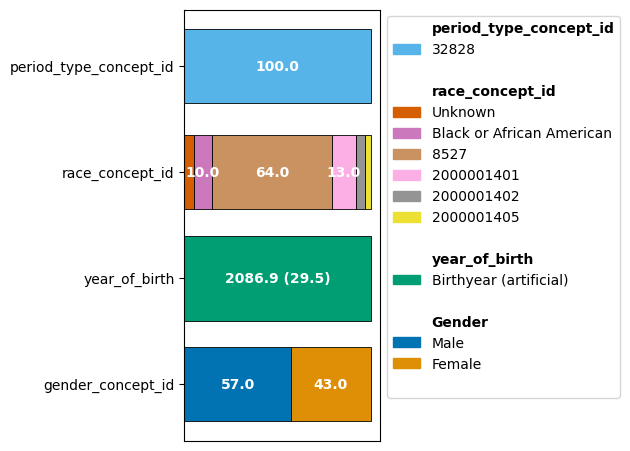

In [62]:
ct = ep.tl.CohortTracker(
    edata,
    columns=["gender_concept_id", "year_of_birth", "race_concept_id", "period_type_concept_id"],
    categorical=["gender_concept_id", "race_concept_id", "period_type_concept_id"],
)

ct(edata)

ct.plot_cohort_barplot(
    legend_labels={
        0: "Unknown",
        8516: "Black or African American",
        "year_of_birth": "Birthyear (artificial)",
        8507: "Male",
        8532: "Female",
    },
    legend_subtitles_names={"gender_concept_id": "Gender"},
)

close connection at the end

In [28]:
con.close()